<a href="https://colab.research.google.com/github/Garimagupta85/Mini-Project-DL/blob/main/cifar10_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification CIFAR10 using Resnet-18





### Data Loading and Preparation

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
ROOT = '.data'
train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .data/cifar-10-python.tar.gz to .data


In [3]:
# Compute means and standard deviations along the R,G,B channel

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image preprocessing modules
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

In [5]:
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [11]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [13]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [14]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

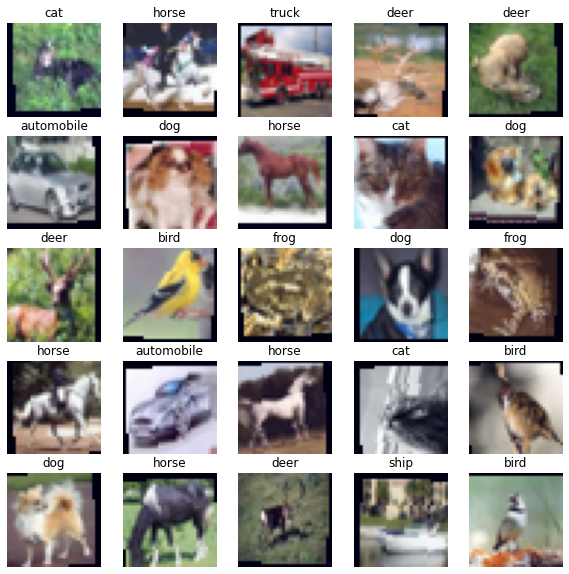

In [17]:
plot_images(images, labels, classes, normalize = True)

In [26]:
from torch.utils.data import DataLoader
BATCH_SIZE = 256

dataloaders = { 'train': torch.utils.data.DataLoader(
                                                  train_data, batch_size=BATCH_SIZE, shuffle=True
                                                  ),
              'test': torch.utils.data.DataLoader(  
                                                  test_data, batch_size=BATCH_SIZE, shuffle=False
                                                  ),
              'valid': torch.utils.data.DataLoader(
                                                  valid_data, batch_size=BATCH_SIZE, shuffle=False
                                                  )
              }

### Initializing Model

In [20]:
model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

11181642


### Training and Evaluation

In [ ]:
#Hyperparameters 

EPOCHS = 1
learning_rate= 0.001
momentum= 0.9

In [34]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

model = model.to(device)
criterion = criterion.to(device)
save_loss = {'train':[], 'valid':[]}
save_acc = {'train':[], 'valid':[]}

In [36]:
for epoch in range(EPOCHS):

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        current_loss = 0.0
        current_corrects = 0

        for batch_idx, (inputs, labels) in enumerate(dataloaders[phase], 1):
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            current_loss += loss.item() * inputs.size(0)
            current_corrects += torch.sum(preds == labels.data)

        save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
        save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]

        print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")

Epoch:0 -- Phase:train -- Loss:1.56 -- Acc:42.58
Epoch:0 -- Phase:valid -- Loss:1.47 -- Acc:45.42
Epoch:1 -- Phase:train -- Loss:1.44 -- Acc:47.92
Epoch:1 -- Phase:valid -- Loss:1.37 -- Acc:49.66


TypeError: ignored

Text(0.5, 1.0, 'Accuracy')

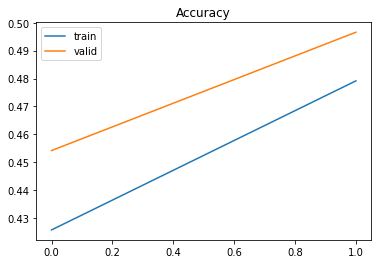

In [37]:
plt.plot(save_acc['train'])
plt.plot(save_acc['valid'])
plt.legend(["train", "valid"])
plt.title("Accuracy")

### Testing and Prediction

In [38]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [40]:
labels = list()
probs = list()

epoch_loss = 0
epoch_acc = 0

model.eval()
with torch.no_grad():
  for (x, y) in dataloaders['test']:
    
    x = x.to(device)
    y = y.to(device)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    probs = probs + preds.tolist()
    labels = labels + y.tolist()
    
    loss = criterion(preds, y)
    acc = calculate_accuracy(preds, y)
    
    epoch_loss += loss.item()
    epoch_acc += acc.item()

test_loss = epoch_loss / len(dataloaders['test'])
test_acc = epoch_acc / len(dataloaders['test'])
print("Test-loss: {} Test-acc: {}".format(test_loss, test_acc))

RuntimeError: ignored

In [ ]:
pred_labels = torch.argmax(torch.FloatTensor(probs), 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)